# CQF - Exam 3

### Imports

In [208]:
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
plt.style.use('seaborn')
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, classification_report, RocCurveDisplay

## A. Maths and Feature Engineering

### 1. Consider MSE($\beta$) wrt to the true value $\beta$ in context of regression methods,

$$
E\left[(\hat{\beta} - \beta)^2\right] = Var[\hat{\beta}] + \left( E[\hat{\beta}] - \beta \right)^2
$$

(a) can there exist an estimator with the smaller MSE than minimal least squares?

<font color='blue'>

The answer is: Yes, may exist a biased estimator with smaller MSE. In this case the estimator would increase a little the bias, $\left( E[\hat{\beta}] - \beta \right)^2$ with a larger decrease in variance term $Var[\hat{\beta}]$.

It is important to note that least square has the smallest mean squared error of all linear estimators **unbiased**.


</font>

(b) for a prediction, does the MSE measure an irreducible error or model error?

<font color='blue'>

The MSE measures the model error, thus the quality of a predictor and is computed as:

$$
MSE = \frac{1}{n} \sum^{n}_{i=1} \left( Y_i - \hat{Y_i} \right)
$$

where $\hat{Y_i}$ is the predicted values by the model.

</font>

### 2. What does entropy say about the partitions in a classification problem?

(a) high entropy means the partitions are pure

(b) high entropy means the partitions are not pure

<font color='blue'>

Answer: (b) Not pure

Entropy is a measure of the randomness in the information being processed. The higher the entropy, the harder it is to draw any conclusions from that information.
It is a measure of disorder or purity or unpredictability or uncertainty.
Low entropy means less uncertain and high entropy means more uncertain.

</font>

### 3. Perform subset selection using any of all of a) filter, b) wrapper and, c) embedded methods

#### Load dataset

Let´s load open, high, low, close prices (dividend adjusted) for PETR4 BZ Equity

In [50]:
df = pd.read_csv('data.csv', index_col='date', parse_dates=['date'])

#### Describe dataset

In [51]:
df.describe()

,open,high,low,close
count,1240.000000,1240.000000,1240.000000,1240.000000
mean,13.421986,13.636153,13.196804,13.414884
std,5.237729,5.339208,5.150517,5.252697
min,4.707236,5.179236,4.613687,4.800786
25%,9.945838,10.127989,9.820758,9.973879
50%,11.684253,11.839912,11.536278,11.706667
75%,16.924746,17.212493,16.624367,16.926054
max,28.526247,30.003359,28.440277,29.479727


In [52]:
df.head()

,open,high,low,close
date,,,,
2018-05-21,10.296750,10.371707,9.839116,9.882513
2018-05-22,9.807405,9.997150,9.546507,9.767875
2018-05-23,9.578131,9.676956,9.198643,9.198643
2018-05-24,7.925775,8.202485,7.767655,7.937634
2018-05-25,8.162955,8.408042,7.771608,7.826950


#### Cleaning & Imputation

Check if data is already cleaned, if so no further manipulation required

In [215]:
df.isnull().sum()

open     0
high     0
low      0
close    0
dtype: int64

### Feature Specification

In [216]:
#create features
def create_features(df_orig):
    df = df_orig.copy()
    df['oc'] = df.open - df.close
    df['hl'] = df.high - df.low
    # momentums
    for i in range(0,10):
        df[f'm{i+1}'] = df.close - df.close.shift(i+1)
    df['ma5'] = df.close.rolling(window=5).mean()
    df['ma10'] = df.close.rolling(window=10).mean()
    df['ewma'] = df.close.ewm(span=len(df.index),adjust=False).mean()
    df.dropna(inplace=True)
    return df


Let´s define the independent variables to be used in the evaluation

In [217]:
df_featured = create_features(df)
df_featured

,open,high,low,close,oc,hl,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,ma5,ma10,ewma
date,,,,,,,,,,,,,,,,,,,
2018-06-05,6.862417,7.036349,6.558035,6.558035,0.304381,0.478314,-0.371582,0.169979,-0.944768,-1.071264,-0.126496,-1.268915,-1.379599,-2.640607,-3.209840,-3.324477,7.001562,7.642345,9.846603
2018-06-06,6.510599,6.593612,6.273419,6.455257,0.055342,0.320193,-0.102778,-0.474361,0.067201,-1.047546,-1.174042,-0.229274,-1.371693,-1.482377,-2.743385,-3.312618,6.766754,7.311083,9.841137
2018-06-07,6.324808,6.388056,5.901837,6.229936,0.094872,0.486220,-0.225321,-0.328099,-0.699682,-0.158120,-1.272868,-1.399364,-0.454596,-1.597014,-1.707698,-2.968707,6.512180,7.014212,9.835318
2018-06-08,6.249701,6.399915,5.953226,6.028333,0.221368,0.446690,-0.201603,-0.426925,-0.529703,-0.901285,-0.359723,-1.474471,-1.600967,-0.656199,-1.798617,-1.909301,6.440236,6.823282,9.829182
2018-06-11,6.127158,6.245748,5.980897,6.091581,0.035577,0.264851,0.063248,-0.138355,-0.363676,-0.466455,-0.838037,-0.296475,-1.411223,-1.537719,-0.592951,-1.735369,6.272628,6.649745,9.823159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-15,26.060000,26.150000,25.400000,25.660000,0.400000,0.750000,-0.590000,0.230000,1.130000,1.070000,1.150000,1.660000,2.640000,3.000000,2.920000,1.960000,25.292000,24.339000,15.142142
2023-05-16,26.110000,27.030000,26.080000,26.300000,-0.190000,0.950000,0.640000,0.050000,0.870000,1.770000,1.710000,1.790000,2.300000,3.280000,3.640000,3.560000,25.634000,24.695000,15.160124
2023-05-17,26.600000,26.760000,25.510000,25.660000,0.940000,1.250000,-0.640000,0.000000,-0.590000,0.230000,1.130000,1.070000,1.150000,1.660000,2.640000,3.000000,25.860000,24.995000,15.177045


#### Feature Selection

Let´s use correlation measure in order to check if we can reduce the number of input variables.

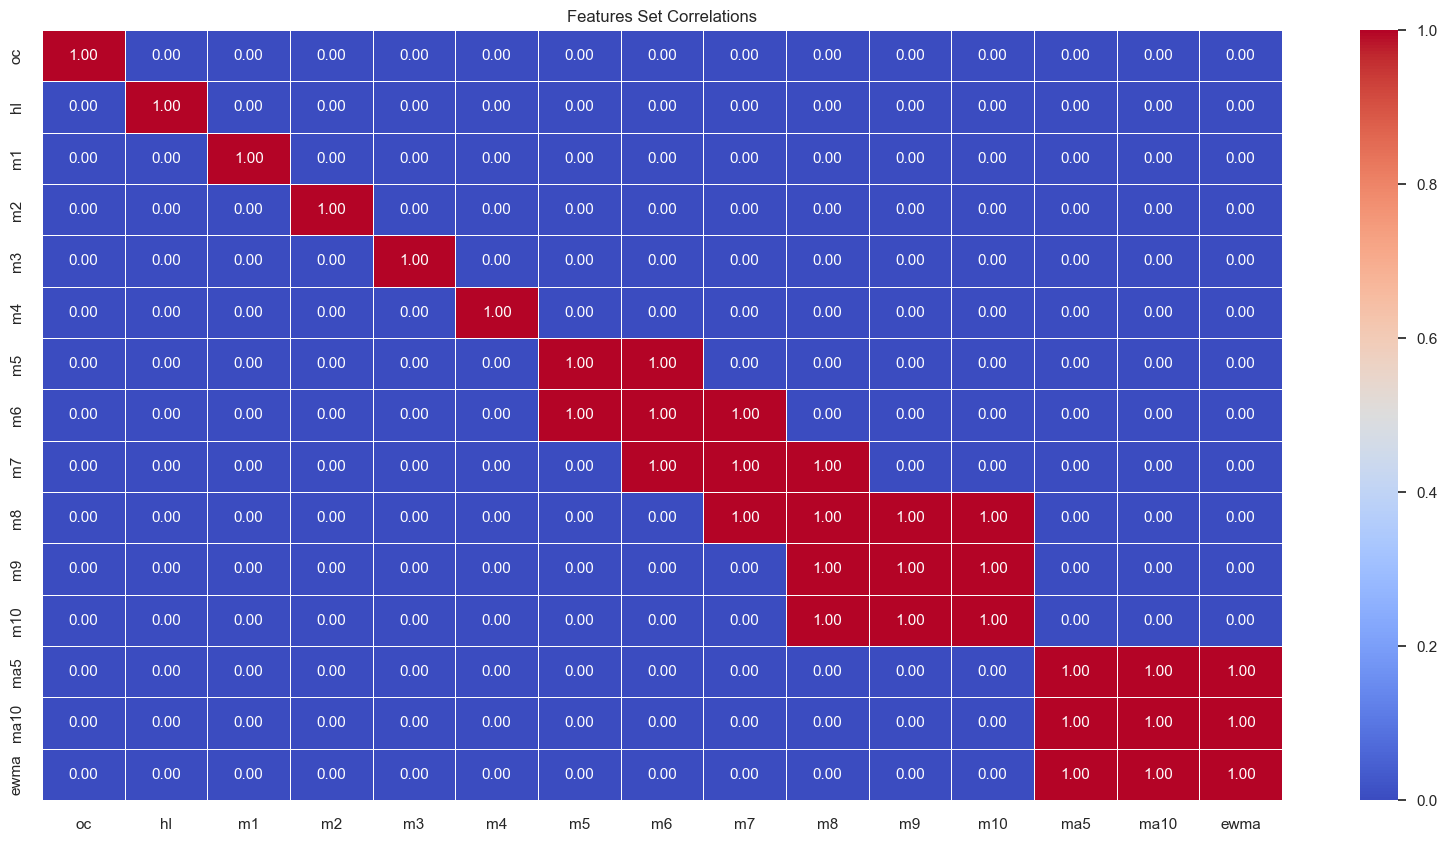

In [218]:
sns.set(rc={'figure.figsize': (20, 10)})

sns.heatmap(df_featured.drop(['open', 'high', 'low', 'close'], axis=1).corr()>0.9, 
            annot=True,  
            annot_kws={"size": 11}, 
            fmt=".2f", 
            linewidth=.5, 
            cmap="coolwarm", 
            cbar=True); #cmap="crest", virids, magma

plt.title('Features Set Correlations');

As we can see, some of the features are high correlated with others and to address multicollinearity among features we will drop some of the them.

In [219]:
to_drop = ['m6', 'm7', 'm8', 'm9', 'ma10', 'ewma']
df_featured.drop(to_drop, axis=1, inplace=True)

Let´s check correlation measure once more

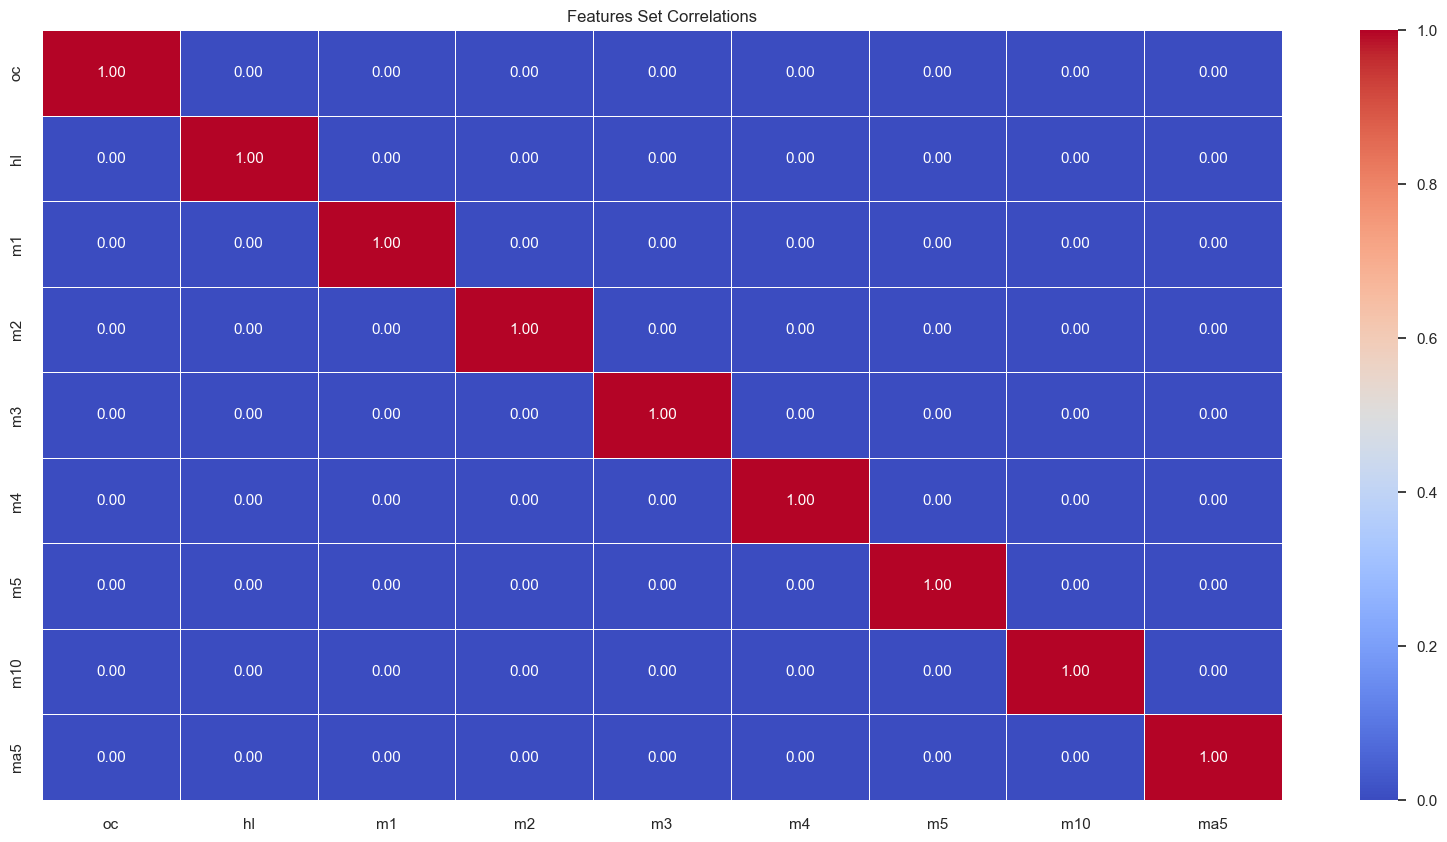

In [220]:
sns.set(rc={'figure.figsize': (20, 10)})

sns.heatmap(df_featured.drop(['open', 'high', 'low', 'close'], axis=1).corr()>0.9, 
            annot=True,  
            annot_kws={"size": 11}, 
            fmt=".2f", 
            linewidth=.5, 
            cmap="coolwarm", 
            cbar=True); #cmap="crest", virids, magma

plt.title('Features Set Correlations');

In [221]:
df_featured.describe()

,open,high,low,close,oc,hl,m1,m2,m3,m4,m5,m10,ma5
count,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000
mean,13.464187,13.678231,13.241037,13.459112,0.005075,0.437194,0.015439,0.031230,0.045991,0.061171,0.076598,0.142205,13.428346
std,5.236895,5.339447,5.146613,5.249874,0.311505,0.299531,0.381179,0.534827,0.650858,0.757934,0.862433,1.282298,5.221452
min,4.707236,5.179236,4.613687,4.800786,-2.039822,0.087497,-2.883023,-3.929075,-4.609435,-4.350048,-5.396100,-8.260888,5.102695
25%,9.996309,10.172188,9.859260,10.012680,-0.140572,0.232959,-0.144960,-0.217823,-0.252091,-0.276400,-0.271357,-0.384587,9.987237
50%,11.708163,11.885520,11.554111,11.720969,0.004252,0.344439,0.013172,0.041760,0.062146,0.089299,0.107995,0.193487,11.727248
75%,16.963984,17.235802,16.674380,16.957445,0.157335,0.544250,0.195549,0.284062,0.363005,0.432088,0.501386,0.743815,17.016040
max,28.526247,30.003359,28.440277,29.479727,1.953853,2.149238,1.860068,2.243023,2.743209,3.384073,3.399703,4.347846,27.833801


#### Target or Label Definition

Now, we will define dependent variable, and for that we will impose a threshold considering positive returns only the ones above 0.25%, thus:

$$
y_t = 
    \begin{cases}
        1, & \text{if $p_{t+1} > 1.0025 * p_t$}\\ 
        0, & \text{if $p_{t+1}$ otherwise}
    \end{cases}
$$

In [282]:
y = np.where(df_featured.close.shift(-1) / df_featured.close > 1.0025, 1, 0)

Generate array X, with the feature set

In [283]:
X = df_featured[['oc','hl','m1', 'ma5']].values

#### Split Data

In [284]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

#### Feature scaling

In [285]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

After performing feature scaling, all values will be normalized and looks like this

In [286]:
pd.DataFrame(data=X_train)

,0,1,2,3
0,0.180279,-0.770954,-0.198210,-0.455644
1,-0.298236,-1.059884,0.030330,-0.449564
2,1.616267,1.821762,-1.275920,1.418526
3,-0.793814,1.135772,0.870673,0.798816
4,0.382914,-0.700072,-0.089247,0.310346
...,...,...,...,...
917,1.434156,0.225632,-1.393878,-0.134913
918,1.820085,0.850007,-1.792237,0.049893
919,3.064085,2.281022,-2.550681,1.967923
920,0.088771,-0.814578,0.010189,-0.720325


In [287]:
model = SVC(kernel = 'rbf', random_state=0)
model.fit(X_train, y_train)

SVC(random_state=0)

In [288]:
y_pred = model.predict(X_test)

In [289]:
pd.DataFrame(data=y_pred)

,0
0,0
1,0
2,0
3,1
4,0
...,...
303,0
304,0
305,0
306,1


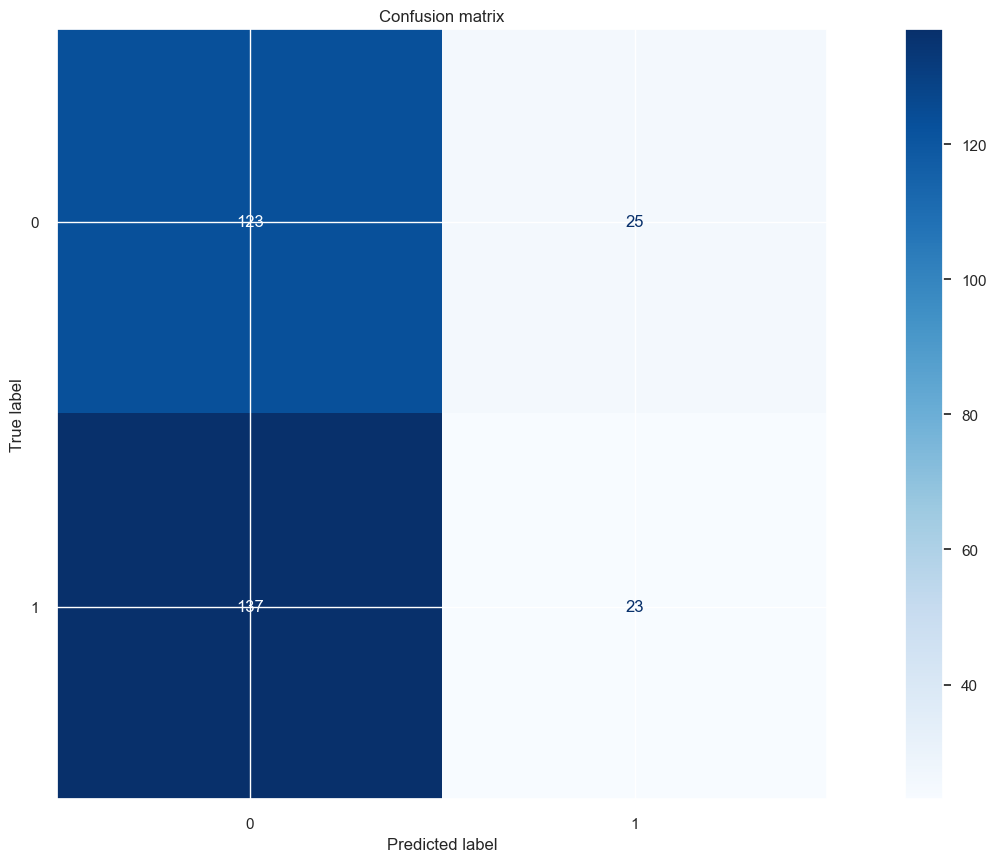

In [290]:
# Display confussion matrix
disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=model.classes_,
        cmap=plt.cm.Blues
    )
disp.ax_.set_title('Confusion matrix')
plt.show()

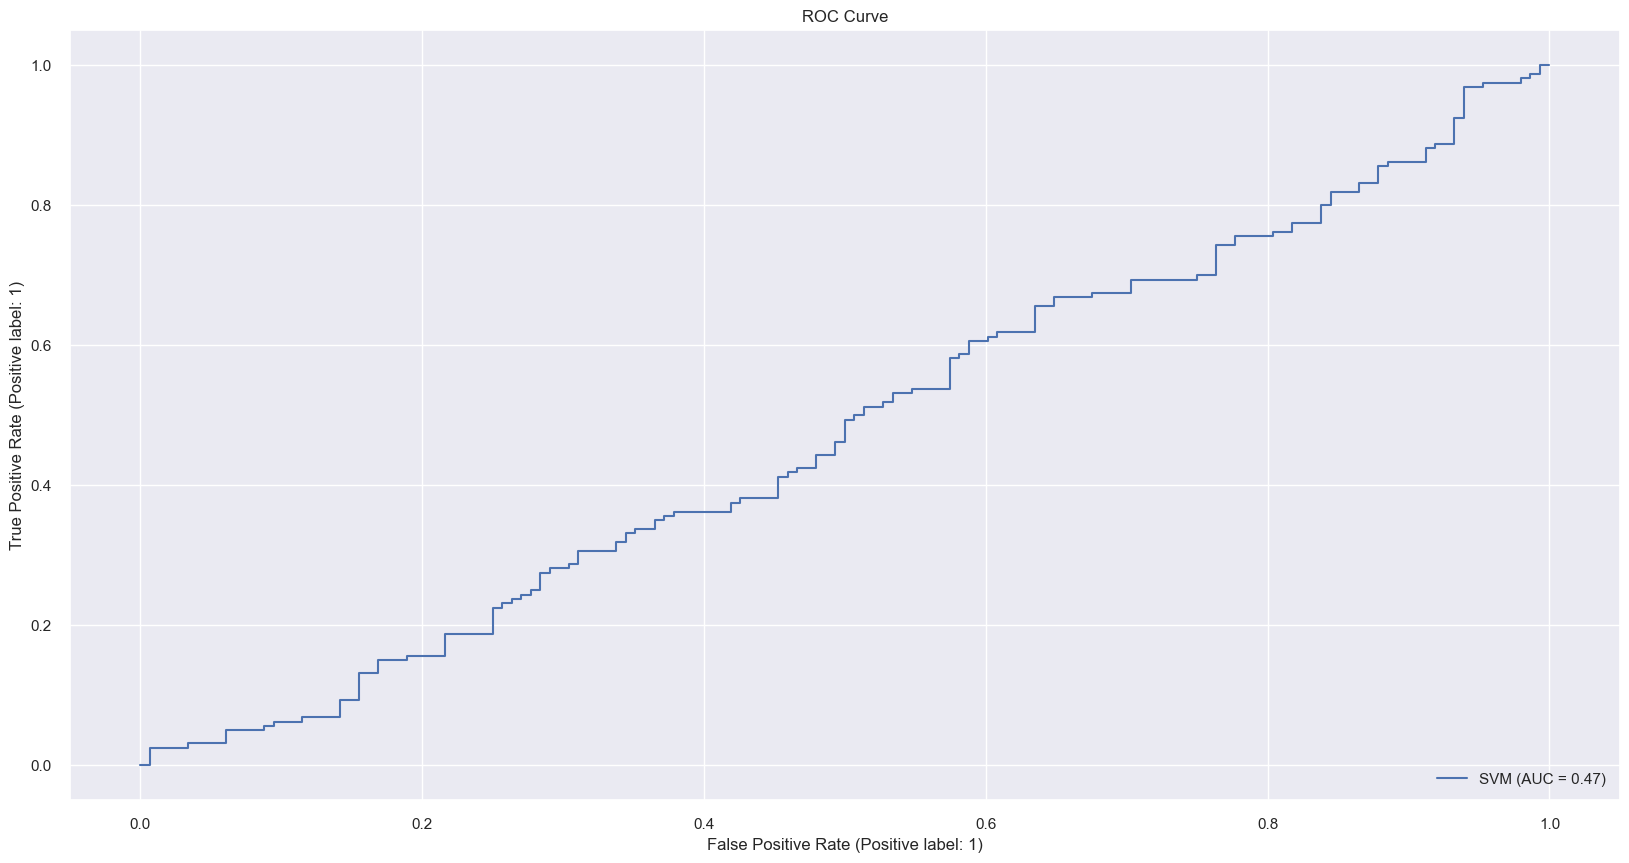

In [291]:
# Display ROCCurve 
disp_roc = RocCurveDisplay.from_estimator(
            model  , 
            X_test, 
            y_test,
            name='SVM')
disp_roc.ax_.set_title('ROC Curve')
plt.show()

In [292]:
accuracy_score(y_test, y_pred)

0.474025974025974

In [293]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.83      0.60       148
           1       0.48      0.14      0.22       160

    accuracy                           0.47       308
   macro avg       0.48      0.49      0.41       308
weighted avg       0.48      0.47      0.40       308



### Hyper-parameter Tuning

#### GridSearch

First we check the parameters available in the model

In [294]:
model.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 0,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

As we are using Gaussian radial basis function (RBF), let´s now search the best C and gamma parameter to be used in the model

In [295]:
param_grid = {'gamma':np.arange(0.0002,99), 'C': np.arange(0.2,99)}
tscv = TimeSeriesSplit(n_splits=3, gap=1)
grid_search = GridSearchCV(model, param_grid, scoring='roc_auc', n_jobs=-1, cv=tscv, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 9801 candidates, totalling 29403 fits


GridSearchCV(cv=TimeSeriesSplit(gap=1, max_train_size=None, n_splits=3, test_size=None),
             estimator=SVC(random_state=0), n_jobs=-1,
             param_grid={'C': array([ 0.2,  1.2,  2.2,  3.2,  4.2,  5.2,  6.2,  7.2,  8.2,  9.2, 10.2,
       11.2, 12.2, 13.2, 14.2, 15.2, 16.2, 17.2, 18.2, 19.2, 20.2, 21.2,
       22.2, 23.2, 24.2, 25.2, 26.2, 27.2, 28.2, 29.2, 30.2, 31.2, 32.2,
       33.2, 34.2, 35.2, 36.2, 37.2, 38.2, 39.2, 40.2, 41.2, 42...
       7.00002e+01, 7.10002e+01, 7.20002e+01, 7.30002e+01, 7.40002e+01,
       7.50002e+01, 7.60002e+01, 7.70002e+01, 7.80002e+01, 7.90002e+01,
       8.00002e+01, 8.10002e+01, 8.20002e+01, 8.30002e+01, 8.40002e+01,
       8.50002e+01, 8.60002e+01, 8.70002e+01, 8.80002e+01, 8.90002e+01,
       9.00002e+01, 9.10002e+01, 9.20002e+01, 9.30002e+01, 9.40002e+01,
       9.50002e+01, 9.60002e+01, 9.70002e+01, 9.80002e+01])},
             scoring='roc_auc', verbose=1)

#### Tunned model

Now, let´s train the model using the best parameter searched

In [296]:
model = SVC(kernel = 'rbf', random_state=0, gamma=grid_search.best_params_['gamma'], C=grid_search.best_params_['C'])
model.fit(X_train, y_train)

SVC(C=96.2, gamma=0.0002, random_state=0)

In [297]:
y_pred = model.predict(X_test)

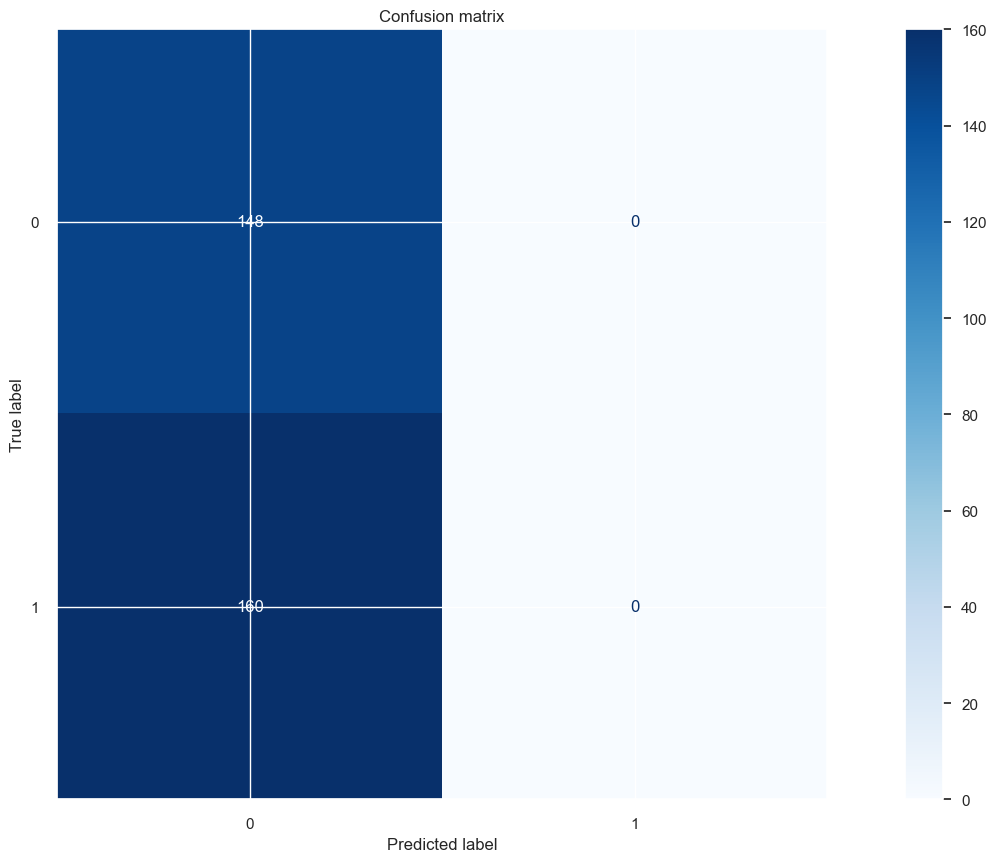

In [298]:
# Display confussion matrix
disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=model.classes_,
        cmap=plt.cm.Blues
    )
disp.ax_.set_title('Confusion matrix')
plt.show()

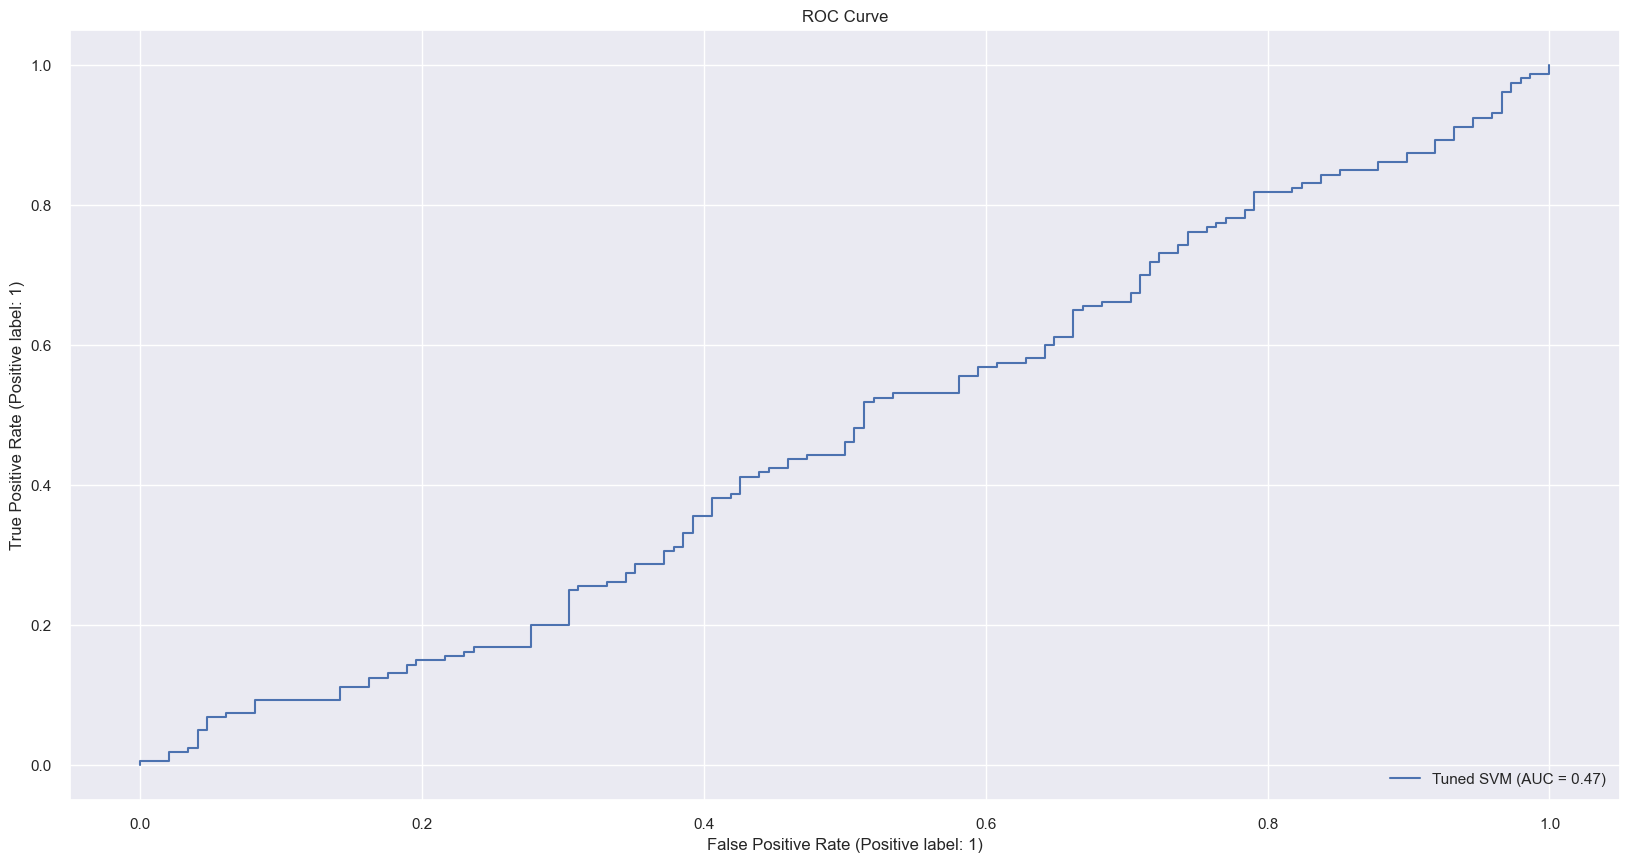

In [299]:
# Display ROCCurve 
disp_roc = RocCurveDisplay.from_estimator(
            model  , 
            X_test, 
            y_test,
            name='Tuned SVM')
disp_roc.ax_.set_title('ROC Curve')
plt.show()

In [300]:
accuracy_score(y_test, y_pred)

0.4805194805194805

In [301]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.48      1.00      0.65       148
           1       0.00      0.00      0.00       160

    accuracy                           0.48       308
   macro avg       0.24      0.50      0.32       308
weighted avg       0.23      0.48      0.31       308



c:\Users\fbris\anaconda3\envs\eqderivs\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\fbris\anaconda3\envs\eqderivs\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\fbris\anaconda3\envs\eqderivs\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Observations**

1. After hyperparametrization, model improved 1.2%
1. Model improved predictor for the uptrend when compared to the downtrend
